In [1]:
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
import numpy as np
import os
import re
import time
import split_extract
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from params import dresden_images_root, images_db_path, patch_span, \
        patch_num, robust_root

In [4]:
# Define image and batch size
img_height = 256
img_width = 256
batch_size = 64

# Load and Compile the model
model = tf.keras.models.load_model('model.h5')

In [5]:
images_db = np.load(images_db_path, allow_pickle=True).item()
# read all the trained model images and unseen model images
real_model_list = list(filter(lambda model: re.search(r'Canon*', model), images_db['brand_model']))
test_model_list = list(filter(lambda model: re.search(r'^((?!Canon).)*$', model), images_db['brand_model']))
test_img_list = list(filter(lambda img: re.search(r'^((?!Canon).)*$', img), images_db['path']))

# How many model in my dataset, real are trained models, test are unseen models
real_model = np.unique(real_model_list) 
test_model = np.unique(test_model_list) 
print("real models: {}".format(', '.join(real_model)))
print("test models: {}".format(', '.join(test_model)))

# test_dir = [os.path.join(robust_root, 'test', model) for model in test_model]
# size_test_data = [len(os.listdir(d)) for d in test_dir]

real models: Canon_Ixus55, Canon_Ixus70, Canon_PowerShotA640
test models: Nikon_CoolPixS710, Nikon_D200, Nikon_D70, Nikon_D70s, Sony_DSC-H50, Sony_DSC-T77, Sony_DSC-W170


In [6]:
test_data_gen = ImageDataGenerator(preprocessing_function=None,
    rescale=1./255)
# Read the positive test samples.
test_generator = test_data_gen.flow_from_directory(
                  directory = r"./robust/test/",
                  target_size=(img_width, img_height), color_mode='grayscale', shuffle=True,
                  batch_size=batch_size, class_mode="categorical")

Found 102100 images belonging to 7 classes.


In [7]:
# generate a histogram, which for every unseen models, how many imgs are classified.
t0 = time.time()
hist = [[0, 0, 0] for i in range(len(test_model))]

for i in range(200):
    gen = next(test_generator)
    pred = model.predict(gen[0])
    pred_labels = np.argmax(pred, axis=1)
    real_labels = np.argmax(gen[1], axis=1)
    for j in range(len(pred_labels)):
        hist[real_labels[j]][pred_labels[j]] += 1
t1 = time.time()
print('It tooks {:d} seconds'.format(int(t1-t0)))

It tooks 112 seconds


                   Canon_Ixus55  Canon_Ixus70  Canon_PowerShotA640
Nikon_CoolPixS710           108          1574                 1230
Nikon_D200                   25          1059                 1244
Nikon_D70                     0          1159                    0
Nikon_D70s                    0          1152                    0
Sony_DSC-H50                  0          1716                    3
Sony_DSC-T77                  0          2218                    0
Sony_DSC-W170                 0          1311                    1


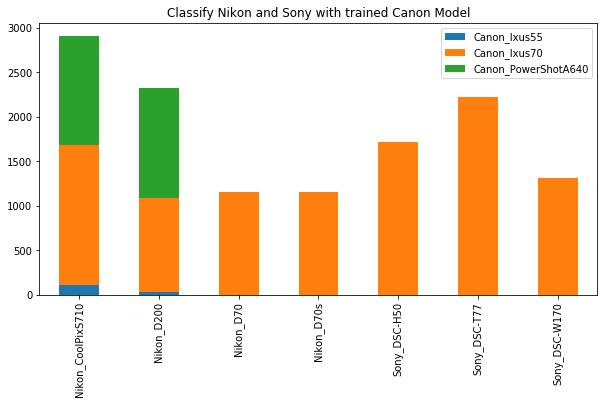

In [8]:
df = pd.DataFrame(hist, index=test_model, columns=real_model)
print(df)

df.plot.bar(stacked=True, figsize=(10, 5), title='Classify Nikon and Sony with trained Canon Model')

In [9]:
# print("real models: {}".format(', '.join(real_model)))


# print("{}: {}".format(', '.join(test_model)))

# num_test_model = len(test_model)
# num_real_model = len(real_model)
# idx = np.arange(num_test_model)    # the x locations for the groups
# width = 0.35       # the width of the bars: can also be len(x) sequence
# plt.figure(figsize=(10,5))

# for n in range(num_real_model):
#     if n == 0:
#         plt.bar(idx, [h[n] for h in hist], width)
#     else:
#         plt.bar(idx, [h[n] for h in hist], width, bottom=[h[n-1] for h in hist])

# plt.title('Classify Nikon and Sony with trained Canon Model')
# plt.ylabel('Number')
# plt.xticks(idx, test_model)
# plt.legend(real_model)
# plt.tight_layout()
# plt.show()